# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Julien Heitmann"
student2 = "Mathias Gonçalves"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.optimizers import SGD, Adam

/home/julien/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import random as rn
import tensorflow as tf

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

### Plotting

In [4]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution Ex 1.1

In [5]:
from keras.datasets import mnist, fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

### Solution Ex 1.2

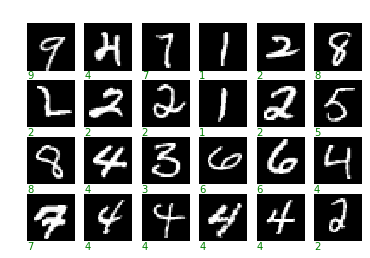

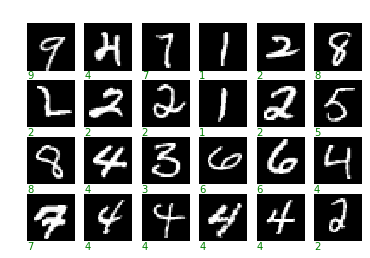

In [0]:
plot_some_samples(x_train, y_train)

The label at the bottom left corner of each image is the number represented by the corresponding picture.

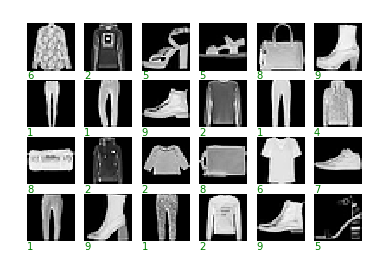

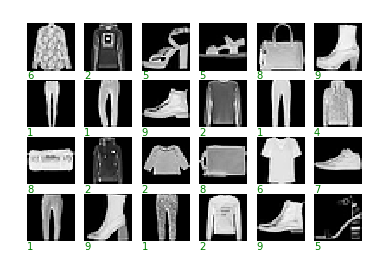

In [0]:
plot_some_samples(x_fashion_train,y_fashion_train)

The green digits at the bottom left of each image indicate its label, every image contains a piece of clothing that falls into one of ten categories, and there is a 1-to-1 mapping between the digits and the categories (0: t-shirt, 1: trouser, etc.).

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [6]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [7]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution Ex 2.1-9

In [8]:
# Defining all the useful functions for exercice 2

def fully_connected_model_creator(input_dim = 784,
                                  layers_n_node = np.asarray([]), 
                                  layers_acti_funcs = np.asarray([]),
                                  output_dim = 10
                                 ):
  """
  Creates a fully connected graph with a certain number of hidden layers
  with a softmax activation function for the output layer
  
    - input_dim: The dimension of the input of the neural network
    - layers_n_node: A numpy array containing the number of nodes in each layer
    - layers_acti_funcs: An numpy array of strings containing the name of
        the activation function for each hidden layer
    - output_dim: The dimension of the output of the neural network
        
    The shape of the layers_n_node array must be the same as the shape
      of layers_acti_funcs array
  """
  
  
  # Making sure the number of layers is the the number of activation functions
  assert layers_n_node.shape[0] == layers_acti_funcs.shape[0]
  
  # Defining the model's architecture 
  model = Sequential()
  
  if layers_n_node.size == 0:
    model.add(Dense(output_dim, input_dim=input_dim))
  else:
    model.add(Dense(layers_n_node[0], input_dim=input_dim))
    model.add(Activation(layers_acti_funcs[0]))
    for ind, n in enumerate(layers_n_node[1:]):
      model.add(Dense(n))
      model.add(Activation(layers_acti_funcs[ind]))
    model.add(Dense(output_dim))
  
  # Softmax activation for the output layer
  model.add(Activation('softmax'))
  
  return model

def create_ex2_model():
  """
  Create the model for Ex2
  """
  # Model Creation
  model = fully_connected_model_creator()

  # Compiling the model
  model.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  # Debug
  print("MODEL SUMMARY:")
  model.summary()
  
  return model

def fit(model, x_tr, y_tr, x_te, y_te):
  """
  Fit the given model with the samples given in argument
  """
  
  return model.fit(
    x_tr,
    y_tr,
    epochs = 100,
    batch_size = 128,
    validation_data = (x_te, y_te),
    callbacks = [keras.callbacks.EarlyStopping()],
    verbose=0
  )
def show_errors(model, x_te, y_te):
  """
  Computes the predicted classes from probablities and plots to error smaples
  """
  
  predictions = model.predict(x_te)
  max_of_output = np.argmax(predictions, axis=1)
  yhat_test = np.zeros(predictions.shape)
  yhat_test[np.arange(max_of_output.shape[0]), max_of_output] = 1
  error_indices = np.argwhere(y_te != yhat_test)
  error_indices = np.unique(error_indices, axis=0)[:,0]
  plot_some_samples(x_te, y_te, yhat_test, error_indices)

MODEL SUMMARY:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


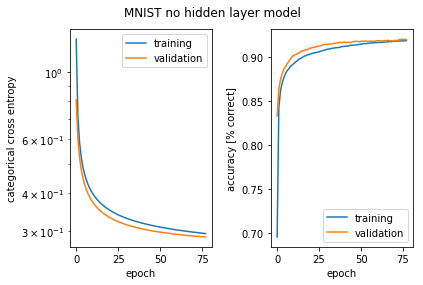

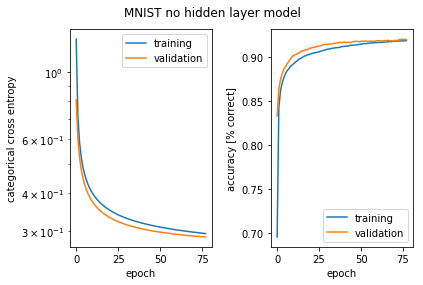

In [0]:
model = create_ex2_model()

# Training the model
history = fit(model, x_train, y_train, x_test, y_test)
plot_history(history, "MNIST no hidden layer model")

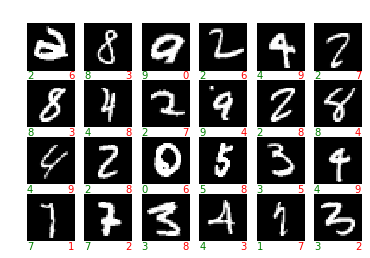

In [0]:
show_errors(model, x_test, y_test)

In the sample plotted here above, the green labels are the correct numbers represented by the corresponding image and the red ones are the values predicted by the model. On some samples, the number written in the image are ambiguous so one can understand that the machine predicted incorrectly but on some other the model predicted a value that has nothing to do with the actual number.

#### Making the same steps for MNIST-Fashion

MODEL SUMMARY:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


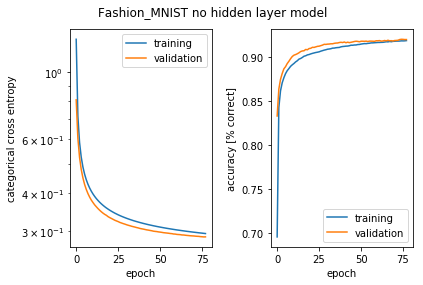

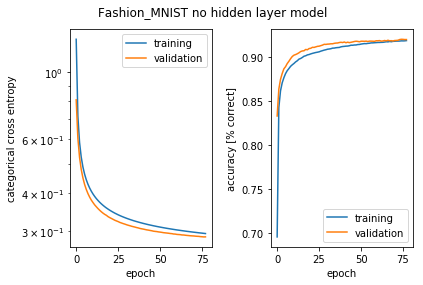

In [0]:
model_fashion = create_ex2_model()

# Training the model
history_fashion = fit(model_fashion, x_fashion_train, y_fashion_train, x_fashion_test, y_fashion_test)
plot_history(history, "Fashion_MNIST no hidden layer model")

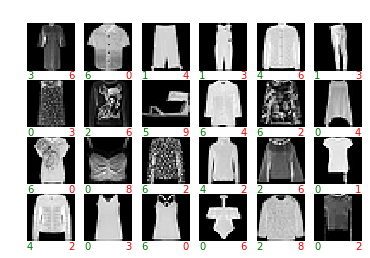

In [0]:
show_errors(model_fashion, x_fashion_test, y_fashion_test)

Answer to question 10:

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

In [9]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

### Solution Ex 3.1

In [11]:
layers_n_node = np.asarray([128])
layers_acti_funcs = np.asarray(['relu'])
model_sgd = fully_connected_model_creator(layers_n_node=layers_n_node, layers_acti_funcs=layers_acti_funcs)
model_sgd.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_sgd.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#### Solution Ex 3.2, 3.3 and 3.4

In [0]:
learning_rates = np.logspace(-2, -1, num=5)

sgd_histories = []
adam_histories = []

for lr in learning_rates:
  
  model_sgd = fully_connected_model_creator(layers_n_node=layers_n_node, layers_acti_funcs=layers_acti_funcs)
  model_sgd.compile(
    optimizer=SGD(lr=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )
  
  sgd_histories.append(
    model_sgd.fit(
      x_train,
      y_train,
      epochs = 50,
      batch_size = 128,
      validation_data = (x_test, y_test),
      verbose=0
    )
  )
  
  model_adam = fully_connected_model_creator(layers_n_node=layers_n_node, layers_acti_funcs=layers_acti_funcs)
  model_adam.compile(
    optimizer=Adam(lr=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )
  
  adam_histories.append(
    model_adam.fit(
      x_train,
      y_train,
      epochs = 50,
      batch_size = 128,
      validation_data = (x_test, y_test),
      verbose=0
    )
  )

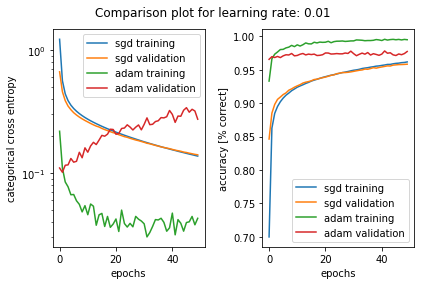

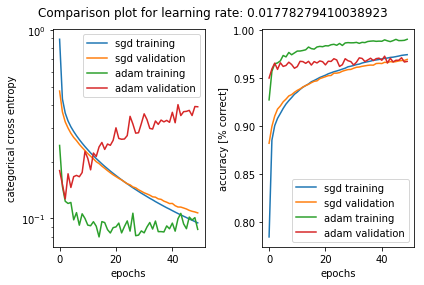

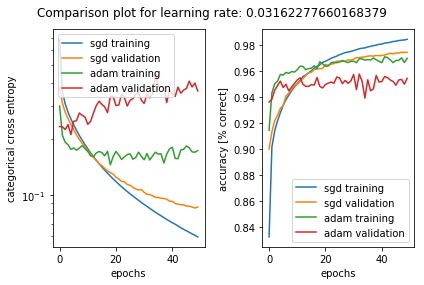

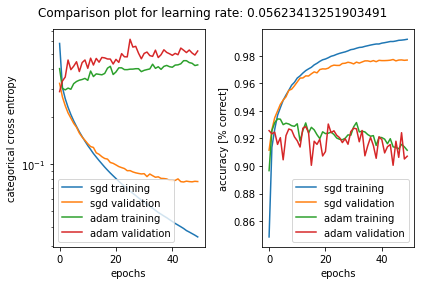

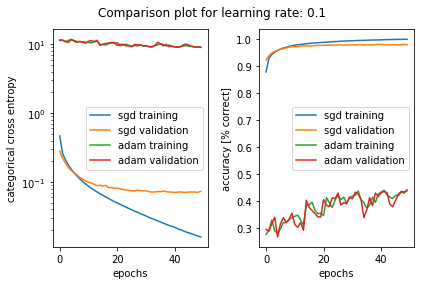

In [0]:
for i, lr in enumerate(learning_rates):
  comparison_plot(sgd_histories[i], adam_histories[i],"sgd", "adam", "Comparison plot for learning rate: " + str(lr))

#### Solution Ex 3.5

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) When the learning rate is large, the accuracy and loss of the sgd optimizer are a lot better than the accuracy and the loss of the adam's optimizer. (Adam doesn't really seem to converge)

B) When the learning rate is small, the accuracy and the loss of the Adam optimizer are a lot better than the accuray and the loss of the sgd optimizer

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: For small learning reates, the adam optimizer doesn't really overfit but for large learning rates, at epoch number 10, we can start to see a decrease of the validation accuracy. (Normally the loss is not taken too much into account for detecting some overfitting but the validation loss never really deacreses, it keeps increasing right from the start)

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: For both accuracy and loss, when the training curve and the validation curve starts to diverge (usually the validation curve gets worst than the training curve) it means that we are overfitting! The accuracy curve for the learing rate 0.031... gives the best example.

#### Solution Ex 3.6

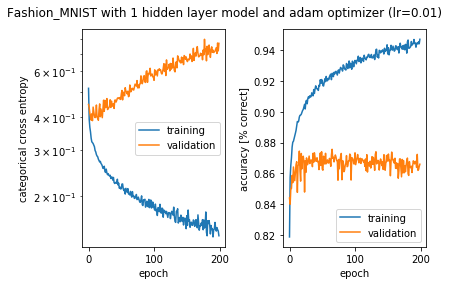

In [12]:
lr = 0.01
model_fashion_mnist_adam = fully_connected_model_creator(layers_n_node=layers_n_node, layers_acti_funcs=layers_acti_funcs)
model_fashion_mnist_adam.compile(
  optimizer=Adam(lr=lr),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

adam_f_mnist_hist = model_fashion_mnist_adam.fit(
  x_fashion_train,
  y_fashion_train,
  epochs = 200,
  batch_size = 128,
  validation_data = (x_fashion_test, y_fashion_test),
  verbose=0
)
fig = plot_history(adam_f_mnist_hist, "Fashion_MNIST with 1 hidden layer model and adam optimizer (lr="+str(lr)+")")

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [0]:
layer_sizes = np.logspace(1, 3, num=5).astype(int)
lr = 0.01
val_accs = []
val_losses = []

for l in layer_sizes:
  model = fully_connected_model_creator(layers_n_node=np.array([int(l)]), layers_acti_funcs=layers_acti_funcs)
  model.compile(
      optimizer=Adam(lr=0.01),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  history = model.fit(
      x_train,
      y_train,
      epochs = 100,
      batch_size = 128,
      validation_data = (x_test, y_test),
      verbose=0
  )
  val_accs.append(np.max(history.history['val_acc']))
  val_losses.append(np.min(history.history['val_loss']))  

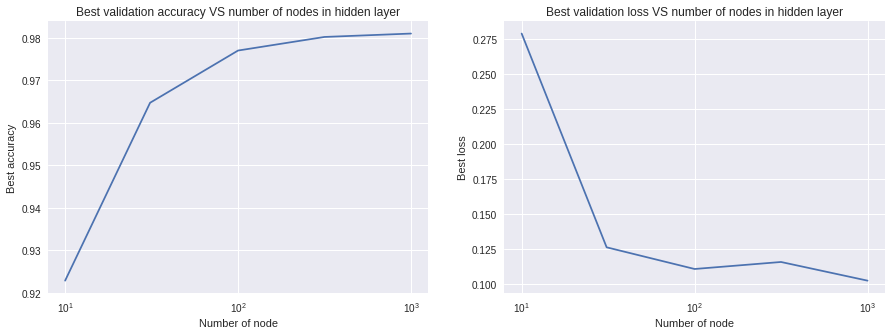

In [0]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.xlabel("Number of node")
plt.ylabel("Best accuracy")
plt.title('Best validation accuracy VS number of nodes in hidden layer')
plt.semilogx(layer_sizes, val_accs)
plt.subplot(1,2,2)
plt.xlabel("Number of node")
plt.ylabel("Best loss")
plt.title('Best validation loss VS number of nodes in hidden layer')
plt.semilogx(layer_sizes, val_losses)
plt.show()

Answer to question 2:

The following plots show that the Universal approximation theorem is indeed respected however, there might be some overfitting for the 1000 nodes case as the minimum loss value increases. (There might be to many parameters for the number of input ploints)

Doing the same procedure for Fashion-MNIST:

In [0]:
layer_sizes = np.logspace(1, 3, num=5).astype(int)
lr = 0.01
val_accs = []
val_losses = []

for l in layer_sizes:
  model = fully_connected_model_creator(layers_n_node = np.array([int(l)]), layers_acti_funcs = layers_acti_funcs)
  model.compile(
      optimizer=Adam(lr=0.01),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  history = model.fit(
      x_fashion_train,
      y_fashion_train,
      epochs = 100,
      batch_size = 128,
      validation_data = (x_fashion_test, y_fashion_test),
      verbose=0
  )
  val_accs.append(np.max(history.history['val_acc']))
  val_losses.append(np.min(history.history['val_loss']))  

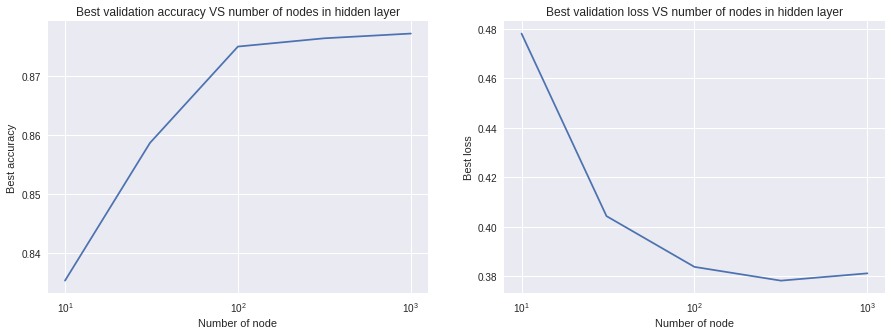

In [0]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.xlabel("Number of node")
plt.ylabel("Best accuracy")
plt.title('Best validation accuracy VS number of nodes in hidden layer')
plt.semilogx(layer_sizes, val_accs)
plt.subplot(1,2,2)
plt.xlabel("Number of node")
plt.ylabel("Best loss")
plt.title('Best validation loss VS number of nodes in hidden layer')
plt.semilogx(layer_sizes, val_losses)
plt.show()

Once again we can see an increase of the accuracy and decrease of the loss as the number of nodes grows! However there might again be a small overfit for the 1000 nodes in the middle layer's model

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [0]:
from keras.layers import BatchNormalization, Dropout
from keras import regularizers

In [0]:
simple_model = fully_connected_model_creator(layers_n_node=np.array([50]),layers_acti_funcs=np.array(["relu"]))

simple_model.compile(
  optimizer=Adam(),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

simple_model.summary()

simple_history = simple_model.fit(
  x_fashion_train,
  y_fashion_train,
  epochs = 115,
  batch_size = 128,
  validation_data = (x_fashion_test, y_fashion_test),
  verbose=0
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 50)                39250     
_________________________________________________________________
activation_7 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                510       
_________________________________________________________________
activation_8 (Activation)    (None, 10)                0         
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


This will serve as our baseline, which we aim to improve. It is a simple deep network with one hidden layer, having 50 nodes. No regularization is done.

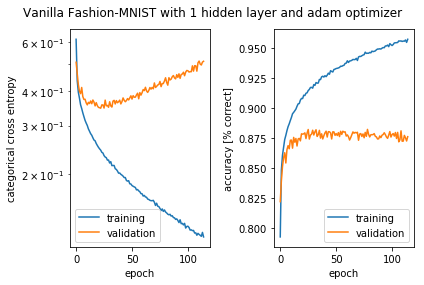

In [0]:
fig = plot_history(simple_history, "Vanilla Fashion-MNIST with 1 hidden layer and adam optimizer")

After only 20  epochs there seems to be some overfitting.

In [0]:
val_loss, val_acc = simple_model.evaluate(x_fashion_test, y_fashion_test, verbose=0)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")

Validation loss: 0.5123547691553831, Validation accuracy: 0.8761


In [0]:
model_with_dropout = Sequential()
model_with_dropout.add(Dense(50, input_shape=(784,)))
model_with_dropout.add(BatchNormalization())
model_with_dropout.add(Activation("relu"))
model_with_dropout.add(Dropout(0.2))
model_with_dropout.add(Dense(10))
model_with_dropout.add(BatchNormalization())
model_with_dropout.add(Activation("softmax"))

model_with_dropout.compile(
  optimizer=Adam(),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

model_with_dropout.summary()

dropout_history = model_with_dropout.fit(
  x_fashion_train,
  y_fashion_train,
  epochs = 115,
  batch_size = 128,
  validation_data = (x_fashion_test, y_fashion_test),
  verbose=0
)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                39250     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
batch_normalization_2 (Batch (None, 10)                40        
___________________________

First attempt is to add a dropout layer after the hidden layer, so that the network becomes less sensitive to the specific weights of neurons and will (hopefully) be capable of better generalization. We also add a batch normalization layer before each layer with trainable parameters. This has a slight regularization effect, as it adds some noise to the activation functions.

In [0]:
val_loss, val_acc = model_with_dropout.evaluate(x_fashion_test, y_fashion_test, verbose=0)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")

Validation loss: 0.4106970358133316, Validation accuracy: 0.8782


Indeed we have a small improvement in validation accuracy of 0.2% compared to baseline. 

In [0]:
model_with_l2 = Sequential()
model_with_l2.add(Dense(50, input_dim=784, activation="relu", kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.0005)))
model_with_l2.add(Dense(10, activation="softmax"))

model_with_l2.compile(
  optimizer=Adam(),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

model_with_l2.summary()

l2_history = model_with_l2.fit(
  x_fashion_train,
  y_fashion_train,
  epochs = 115,
  batch_size = 128,
  validation_data = (x_fashion_test, y_fashion_test),
  verbose=0
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_34 (Dense)             (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


Next step is to try a more standard regularization technique, L1/L2 weight regularization, which applies a penalty on large weight vectors. 

In [0]:
val_loss, val_acc = model_with_l2.evaluate(x_fashion_test, y_fashion_test, verbose=0)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")

Validation loss: 0.39245203239917753, Validation accuracy: 0.8801


Again, there is a small improvement in validation accuracy.

In [0]:
final_model = Sequential()
final_model.add(BatchNormalization(input_shape=(784,)))
final_model.add(Dense(50, activation="relu", bias_regularizer=regularizers.l2(0.0005)))
final_model.add(Dropout(0.2))
final_model.add(BatchNormalization())
final_model.add(Dense(10, activation="softmax"))

final_model.compile(
  optimizer=Adam(),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

final_model.summary()

final_history = final_model.fit(
  x_fashion_train,
  y_fashion_train,
  epochs = 115,
  batch_size = 128,
  validation_data = (x_fashion_test, y_fashion_test),
  verbose=0
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_41 (Batc (None, 784)               3136      
_________________________________________________________________
dense_59 (Dense)             (None, 50)                39250     
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 50)                200       
_________________________________________________________________
dense_60 (Dense)             (None, 10)                510       
Total params: 43,096
Trainable params: 41,428
Non-trainable params: 1,668
_________________________________________________________________


This setting was found after trying multiple combinations of regularization techniques, and tweeking the hyperparameters. 

In [0]:
val_loss, val_acc = final_model.evaluate(x_fashion_test, y_fashion_test, verbose=0)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")

Validation loss: 0.39910079416632654, Validation accuracy: 0.8829


The baseline validation accuracy was improved by approximately 0.8%.

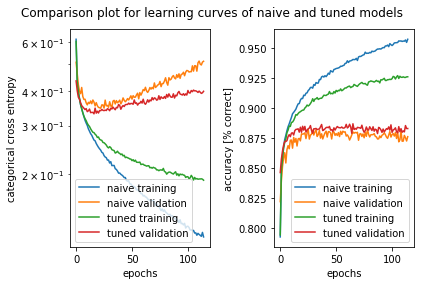

In [0]:
fig = comparison_plot(simple_history,final_history,"naive","tuned","Comparison plot for learning curves of naive and tuned models")

Answer to question 2 (comments): as we can see, adding dropout with probability 0.2 and a bias regularizer reduces overfitting, but does not manage to get entirely rid of it. Introducing an early-stop might enhance performance. Nonetheless, this model performs slightly better than the naive model with no regularization technique.



In [0]:
final_model = Sequential()
final_model.add(BatchNormalization(input_shape=(784,)))
final_model.add(Dense(50, activation="relu", bias_regularizer=regularizers.l2(0.0005)))
final_model.add(Dropout(0.2))
final_model.add(BatchNormalization())
final_model.add(Dense(10, activation="softmax"))

final_model.compile(
  optimizer=Adam(),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

final_model.summary()

final_history = final_model.fit(
  x_train,
  y_train,
  epochs = 115,
  batch_size = 128,
  validation_data = (x_test, y_test),
  verbose=0
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_43 (Batc (None, 784)               3136      
_________________________________________________________________
dense_61 (Dense)             (None, 50)                39250     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 50)                200       
_________________________________________________________________
dense_62 (Dense)             (None, 10)                510       
Total params: 43,096
Trainable params: 41,428
Non-trainable params: 1,668
_________________________________________________________________


The best performing model is fitted to MNIST. This will serve as a reference for the next exercise.

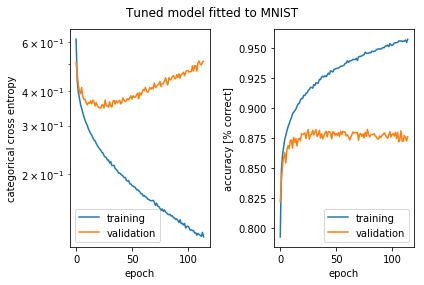

In [0]:
fig = plot_history(simple_history, "Tuned model fitted to MNIST")

In [0]:
val_loss, val_acc = final_model.evaluate(x_test, y_test, verbose=0)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_acc}")

Validation loss: 0.14738598946147832, Validation accuracy: 0.9706


## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

model.summary()

cnn_history = model.fit(x_train.reshape(x_train.shape[0],28,28,1), y_train,
          batch_size=128,
          epochs=100,
          verbose=0,
          validation_data=(x_test.reshape(x_test.shape[0],28,28,1), y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
__________

After trying multiple architectures, the model proposed by Keras to solve the MNIST classification problem seems to be good enough.

In [0]:
score = model.evaluate(x_test.reshape(x_test.shape[0],28,28,1), y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.041188022635066115
Test accuracy: 0.9936


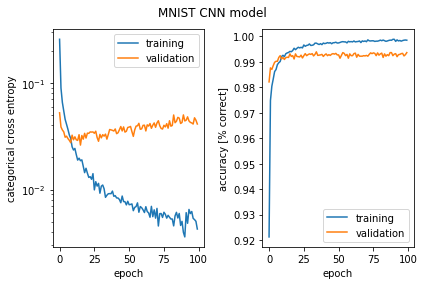

In [0]:
fig = plot_history(cnn_history, "MNIST CNN model")

In [0]:
fs_model = Sequential()
fs_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
fs_model.add(Conv2D(64, (3, 3), activation='relu'))
fs_model.add(MaxPooling2D(pool_size=(2, 2)))
fs_model.add(Dropout(0.25))
fs_model.add(Flatten())
fs_model.add(Dense(128, activation='relu'))
fs_model.add(Dropout(0.5))
fs_model.add(Dense(10, activation='softmax'))

fs_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

fs_model.summary()

fs_history = fs_model.fit(x_fashion_train.reshape(x_train.shape[0],28,28,1), y_fashion_train,
          batch_size=128,
          epochs=100,
          verbose=0,
          validation_data=(x_fashion_test.reshape(x_fashion_test.shape[0],28,28,1), y_fashion_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
__________

In [0]:
score = fs_model.evaluate(x_fashion_test.reshape(x_test.shape[0],28,28,1), y_fashion_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.38850919687803837
Test accuracy: 0.9326


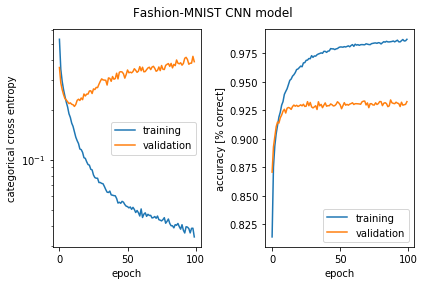

In [0]:
fig = plot_history(fs_history, "Fashion-MNIST CNN model")

Answer to question 3:

The CNN performs significantly better than the so far best performing neural network model for the two datasets. When fitted to the Fashion-MNIST, the validation accuracy increases from 0.8829 to 0.9326, which is a lot, considering how applying regularization techniques in the previous problem improved the validation accuracy by less than 1%.

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [0]:
sigmoid_model = Sequential()
sigmoid_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid',
                 input_shape=(28,28,1)))
sigmoid_model.add(Conv2D(64, (3, 3), activation='sigmoid'))
sigmoid_model.add(MaxPooling2D(pool_size=(2, 2)))
sigmoid_model.add(Dropout(0.25))
sigmoid_model.add(Flatten())
sigmoid_model.add(Dense(128, activation='sigmoid'))
sigmoid_model.add(Dropout(0.5))
sigmoid_model.add(Dense(10, activation='softmax'))

sigmoid_model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

sigmoid_model.summary()

sigmoid_history = sigmoid_model.fit(x_fashion_train.reshape(x_fashion_train.shape[0],28,28,1), y_fashion_train,
          batch_size=128,
          epochs=50,
          verbose=0,
          validation_data=(x_fashion_test.reshape(x_fashion_test.shape[0],28,28,1), y_fashion_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

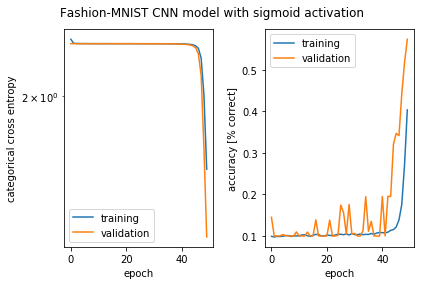

In [0]:
fig = plot_history(sigmoid_history, "Fashion-MNIST CNN model with sigmoid activation")

In [0]:
normalized_model = Sequential()
normalized_model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
normalized_model.add(BatchNormalization())
normalized_model.add(Activation("sigmoid"))
normalized_model.add(Conv2D(64, (3, 3)))
normalized_model.add(BatchNormalization())
normalized_model.add(Activation("sigmoid"))
normalized_model.add(MaxPooling2D(pool_size=(2, 2)))
normalized_model.add(Dropout(0.25))
normalized_model.add(Flatten())
normalized_model.add(Dense(128))
normalized_model.add(BatchNormalization())
normalized_model.add(Activation("sigmoid"))
normalized_model.add(Dropout(0.5))
normalized_model.add(Dense(10))
normalized_model.add(BatchNormalization())
normalized_model.add(Activation("softmax"))

normalized_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

normalized_model.summary()

normalized_history = normalized_model.fit(x_train.reshape(x_train.shape[0],28,28,1), y_train,
          batch_size=128,
          epochs=50,
          verbose=0,
          validation_data=(x_test.reshape(x_test.shape[0],28,28,1), y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
__________

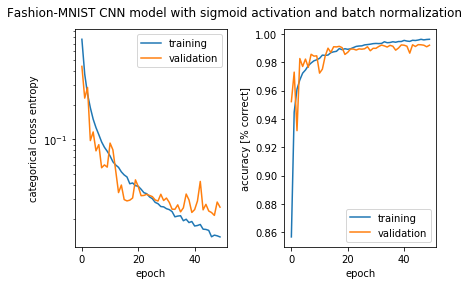

In [0]:
fig = plot_history(normalized_history, "Fashion-MNIST CNN model with sigmoid activation and batch normalization")

In [0]:
score = normalized_model.evaluate(x_test.reshape(x_test.shape[0],28,28,1), y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.025328664581454358
Test accuracy: 0.992


Answer to question 1:

When fitting a CNN with sigmoid activation functions to the MNIST dataset, it can be seen that for the first 40 epochs, there is almost no change in the value of the loss function, for both the training and the validation set. The curve representing the evolution of the loss function seems to be flat before dropping suddenly after more than 40 epochs. This is known as the "vanishing gradient problem", where the gradient will be vanishingly small, effectively preventing the weight of a node from changing its value.

Answer to question 2:

Batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. Considering the shape of the sigmoid function, the zero-mean output of a BatchNormalization layer is much more likely to have a non-vanishing gradient at each layer than the output of an activation layer with no subsequent normalization. This helps avoiding the "vanishing gradient problem", as the history plot of the improved model shows. The network can even reach the performance of the ReLU-CNN, its test accuracy is only slightly worse. Note that the ReLU-CNN was trained twice as long, which might explain the difference in performance.